
# Image Classification Using pretrained CNN

Finetuning a model from https://github.com/timesler/facenet-pytorch, pretrained on VGGFace2


## Download the files 💾

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install aicrowd-cli
%load_ext aicrowd.magic

In [29]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/J9a2-03Rc_E8XCxLqdIo7dq54xMSbUnWt2KhPJW9CNQ
API Key valid
Gitlab access token valid
Saved details successfully!


In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c age-prediction -o data

sample_submission.csv:   0%|          | 0.00/36.0k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/36.0k [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/176M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/48.3k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/236M [00:00<?, ?B/s]

val.csv:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/117M [00:00<?, ?B/s]

In [ ]:
!unzip -qq data/train.zip -d data/train
!unzip -qq data/val.zip -d data/val
!unzip -qq data/test.zip -d data/test

## Importing Libraries:



In [ ]:
!pip install facenet_pytorch

In [ ]:
import pandas as pd
import numpy as np
import torch
import csv
import os
import cv2
import glob
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import albumentations as albu
from facenet_pytorch import InceptionResnetV1, MTCNN

## Visualising data:



In [ ]:
def open_img(name):
    img = cv2.imread(name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def show(img):
    plt.xticks([]), plt.yticks([])
    plt.imshow(img)


def show_all(images, cols=3):
    num_rows = (len(images) - 1) // cols + 1
    plt.rcParams['figure.figsize'] = [20, 7 * num_rows]
    for i, im in enumerate(images):
        plt.subplot(num_rows, cols, i+1)
        show(im)
    plt.show()
    plt.rcParams['figure.figsize'] = [20, 10]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

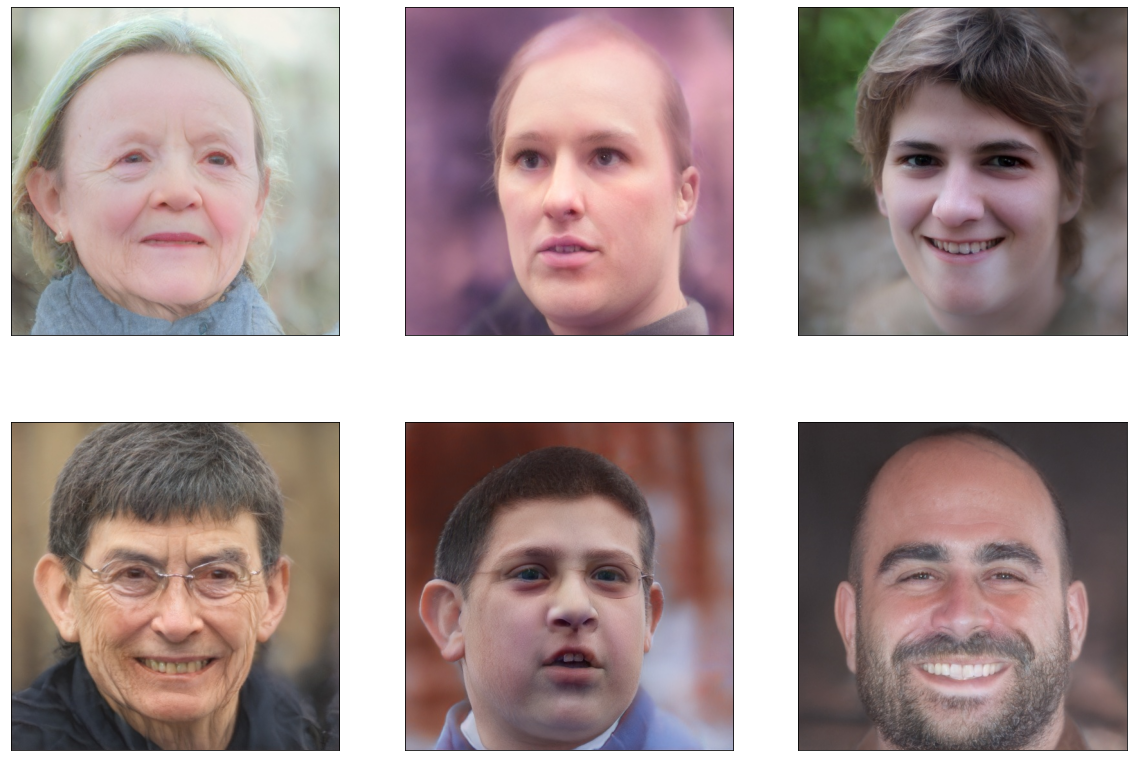

In [16]:
names = ["0000v", "00boq", "01bn8", "03p0f", "04gd1", "04tx0"]
# names = ["dloyr", "e6yjc", "k675i", "ni3p4", "ro01p", "svx4s"]
imgs = [open_img("data/val/"+name+".jpg") for name in names]

show_all(imgs)

## Cropping and preprocessing:

In [ ]:
!mkdir data/val_cropped
!mkdir data/train_cropped
!mkdir data/test_cropped

In [ ]:
mtcnn = MTCNN(select_largest=False, device=device)
with torch.no_grad():
    for folder in ("val", "train", "test"):
        print(folder)
        for name in tqdm(sorted(glob.glob(f"data/{folder}/*"))):
            img = open_img(name)
            img = mtcnn(img)
            if img is None:
                continue
            name = f"data/{folder}_cropped/{name[5+len(folder)+1:-4]}"
            np.save(name, img)
        
["41sdq", "5hdpj", "jy2ia", "4nwng", "gft1g", "j3adj", "pgy06", "qino8", "vrr48", "ywvd0"]
["dloyr", "e6yjc", "k675i", "ni3p4", "ro01p", "svx4s"]

val


100%|██████████| 1999/1999 [02:20<00:00, 14.19it/s]


train


100%|██████████| 4000/4000 [04:26<00:00, 15.00it/s]


test


100%|██████████| 3000/3000 [03:22<00:00, 14.85it/s]


['dloyr', 'e6yjc', 'k675i', 'ni3p4', 'ro01p', 'svx4s']

## Data loading:

In [ ]:
transform = albu.Compose([
        albu.HorizontalFlip(p=0.5),
        albu.GaussNoise(var_limit=(1, 100.0), p=1),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(limit=0.9, p=1),
                albu.RandomGamma(gamma_limit=(1, 200), p=1),
            ],
            p=1,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=(2, 15), p=1),
                albu.MotionBlur(blur_limit=(3, 30), p=1),
            ],
            p=1,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(limit=(-0.6, 0.6), p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=1,
        ),
    ])

name2id = {"0-10": 0, "10-20": 1, "20-30": 2, "30-40": 3, "40-50": 4, "50-60": 5, "60-70": 6, "70-80": 7, "80-90": 8, "90-100": 9}
id2name = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80-90", "90-100"]

class DataSet(torch.utils.data.Dataset):
    def __init__(self, phase):
        self.names = []
        self.labels = []
        self.phase = phase
        with open(f'data/{phase}.csv') as f:
            reader = csv.reader(f)
            for row in reader:
                break
            for row in reader:
                name = row[0]
                if name in ["41sdq", "5hdpj", "jy2ia", "4nwng", "gft1g", "j3adj", "pgy06", "qino8", "vrr48", "ywvd0"]:
                    continue
                self.names.append(name)
                label = torch.tensor(name2id[row[1]])
                self.labels.append(label)
        self.labels = torch.stack(self.labels)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        img = np.load(f"data/{self.phase}_cropped/{self.names[idx]}.npy")

        img[0] -= img[0].mean()
        img[1] -= img[1].mean()
        img[2] -= img[2].mean()

        if self.phase == "train":
            lo, hi = img.min(), img.max()
            img = (img-lo)/(hi-lo) * 255
            img = np.array(img, dtype=np.uint8)
            img = np.transpose(img, axes=[1, 2, 0])
            img = transform(image=img)["image"]
            img = np.transpose(img, axes=[2, 0, 1])
            img = torch.from_numpy(img)
            img = (img.float() - 128) / 128

        return img, self.labels[idx], self.names[idx]


In [ ]:
valDataSet = DataSet('val')
trainDataSet = DataSet('train')

batch_size=256
valLoader = torch.utils.data.DataLoader(valDataSet, batch_size=batch_size, shuffle=False, num_workers=2)
trainLoader = torch.utils.data.DataLoader(trainDataSet, batch_size=batch_size, shuffle=False, num_workers=2)

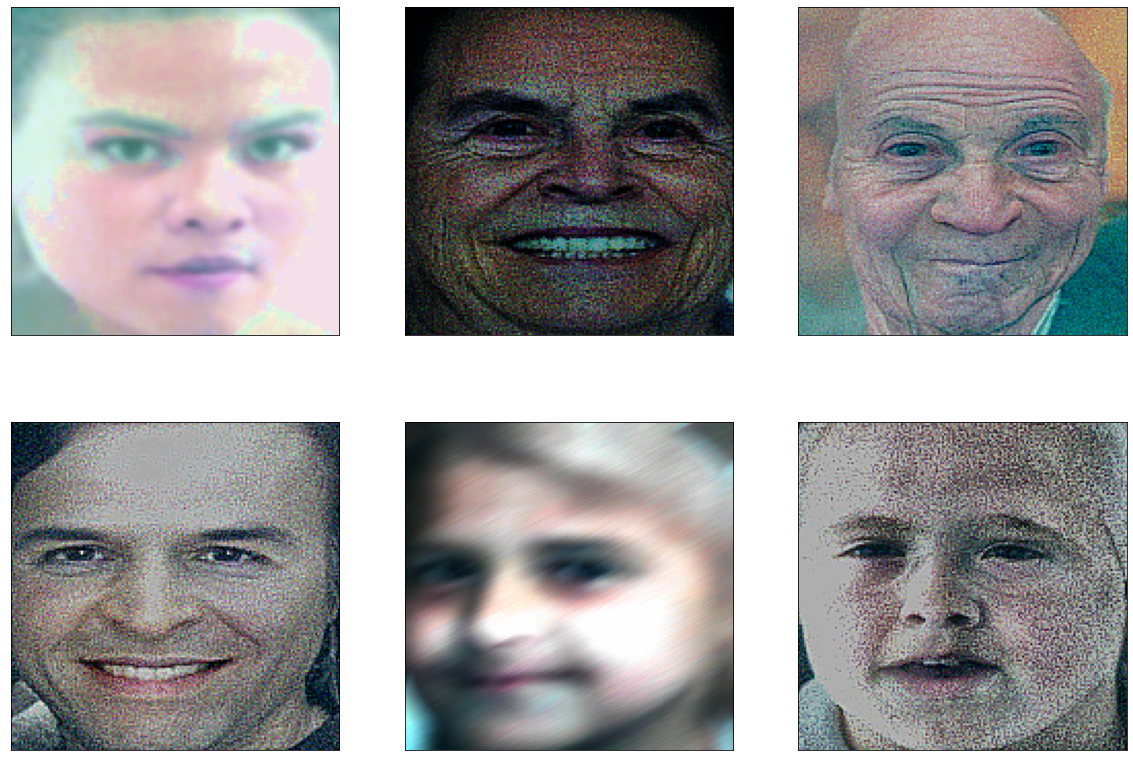

In [ ]:
# Reduce batch_size before running this cell
for imgs, lbl, names in trainLoader:
    imgs = imgs.permute(0, 2, 3, 1)
    imgs = imgs / 2 + 0.5
    show_all(imgs)
    break

In [ ]:
class TestDataSet(torch.utils.data.Dataset):
    def __init__(self):
        self.names = []
        with open(f'data/test.csv') as f:
            reader = csv.reader(f)
            for row in reader:
                break
            for row in reader:
                name = row[0]
                if name in ["dloyr", "e6yjc", "k675i", "ni3p4", "ro01p", "svx4s"]:
                    continue
                self.names.append(name)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        img = np.load(f"data/test_cropped/{self.names[idx]}.npy")

        img[0] -= img[0].mean()
        img[1] -= img[1].mean()
        img[2] -= img[2].mean()

        return img, self.names[idx]

In [ ]:
testDataSet = TestDataSet()

batch_size=256
testLoader = torch.utils.data.DataLoader(testDataSet, batch_size=batch_size, shuffle=False, num_workers=2)

## Training:

In [ ]:
def save(filename, model):
    filename = "drive/My Drive/state_dicts/" + filename
    torch.save(model.state_dict(), filename)
    print("Saved model as", filename)

def load(filename, net=None):
    if net == None:
        net = InceptionResnetV1(pretrained='vggface2', num_classes=10, classify=True).eval().to(device)

    try:
        net.load_state_dict(torch.load("drive/My Drive/state_dicts/"+filename))
        print("Loaded", filename)
    except Exception as e:
        print("starting from new state", e)
    return net.to(device)

In [ ]:
name = "age_classify2"
net = load("age_classify2_tmp")
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(net.parameters(), lr=1e-4)

best_accuracy = 79
try:
    for epoch in range(7):
        train_correct = 0
        net.train()
        for i, batch in enumerate(trainLoader):
            x, y = batch[0].to(device), batch[1].to(device).long()

            optimiser.zero_grad()
            output = net(x)
            loss = criterion(output, y)
            train_correct += torch.sum(y == output.argmax(1)).item()
            loss.backward()
            optimiser.step()

        net.eval()
        with torch.no_grad():
            val_correct = 0
            val_loss = 0
            for batch in valLoader:
                x, y = batch[0].to(device), batch[1].to(device)
                out = net(x)

                predicted = out.argmax(1)
                loss = criterion(out, y)

                val_loss += loss.item()
                val_correct += torch.sum(y == predicted).item()

        train_accuracy = 100 * train_correct / len(trainDataSet)
        val_accuracy = 100 * val_correct / len(valDataSet)
        print(f"Epoch {epoch+1}   train accuracy: {train_accuracy}, val accuracy: {val_accuracy}, loss: {val_loss}")
        if val_accuracy > best_accuracy:
            print("saving at epoch", epoch+1)
            best_accuracy = val_accuracy
            save(name+"_tmp", net)

except KeyboardInterrupt:
    save(name+"_end", net)

## Generating Prediction File

In [37]:
submission = pd.read_csv('data/sample_submission.csv')

In [38]:
outputs = {}
net.eval()
with torch.no_grad():
    val_correct = 0
    val_loss = 0
    for batch in testLoader:
        x, names = batch[0].to(device), batch[1]
        out = net(x)

        ages = out.argmax(1)
        for age, name in zip(ages, names):
            outputs[name] = id2name[age]

# if the face was not found in the image during preprocessing just make a random guess - 20-30
for i, row in enumerate(submission['ImageID']):
    submission['age'][i] = outputs[row] if row in outputs else "20-30"

In [39]:
!rm -rf assets
!mkdir assets
submission.to_csv(os.path.join("assets", "submission.csv"))


# Submitting our Predictions

Note : Please save the notebook before submitting it (Ctrl + S)


In [ ]:
%aicrowd notebook submit -c age-prediction -a assets --no-verify

Using notebook: Age Prediction using pretrained CNN for submission...
Removing existing files from submission directory...
Scrubbing API keys from the notebook...


Output()